# Data Import and Loading

In [11]:
pip install cartopy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\Samuel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle, geodesic
from shapely.geometry import MultiPoint
import kagglehub
import os

# File paths for the Amazon delivery dataset and the Indian Cities database
#pathDelivery = '/content/drive/MyDrive/Portfólio/Rede delivery/delivery.csv' # Data from: https://www.kaggle.com/datasets/sujalsuthar/amazon-delivery-dataset/
#pathCities = '/content/drive/MyDrive/Portfólio/Rede delivery/Indian_Cities.csv' # Data from: https://www.kaggle.com/datasets/zed9941/top-500-indian-cities
# Download dos datasets
pathCitiesDir = kagglehub.dataset_download("zed9941/top-500-indian-cities")
pathDeliveryDir = kagglehub.dataset_download("sujalsuthar/amazon-delivery-dataset")

# Função auxiliar para encontrar o primeiro CSV dentro da pasta
def get_csv_path(directory):
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    return os.path.join(directory, files[0])
csvDelivery = get_csv_path(pathDeliveryDir)
csvCities = get_csv_path(pathCitiesDir)

# Load dataframes
dfDelivery = pd.read_csv(csvDelivery)
dfCities = pd.read_csv(csvCities)

# Consider only geospatial information
dfDelivery = dfDelivery.loc[:,['Store_Latitude', 'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude']]

# Consider city, state, population and geospatial information
dfCities = dfCities.loc[:,['name_of_city',	'state_name',	'population_total', 'location']]

# Get the coordinates of each city
dfCities['location'] = dfCities['location'].apply(lambda x: tuple(x.replace(' ', '').split(',')))

# Statistical and Integrity Exploration

In [36]:
# Verification of types and null values
print("--- Delivery Dataset Info ---")
print(dfDelivery.info())

# Descriptive statistics of the coordinates
print("\n--- Coordinate Statistics ---")
print(dfDelivery.describe())

# Verification of Geographic Outliers (India is approx. between Lat [8, 37] and Long [68, 97])
outliers_lat = dfDelivery[(dfDelivery['Store_Latitude'] < 5) | (dfDelivery['Store_Latitude'] > 40)]
print(f"\nRecords outside India's expected latitude: {len(outliers_lat)}")

--- Delivery Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Store_Latitude   43739 non-null  float64
 1   Store_Longitude  43739 non-null  float64
 2   Drop_Latitude    43739 non-null  float64
 3   Drop_Longitude   43739 non-null  float64
dtypes: float64(4)
memory usage: 1.3 MB
None

--- Coordinate Statistics ---
       Store_Latitude  Store_Longitude  Drop_Latitude  Drop_Longitude
count    43739.000000     43739.000000   43739.000000    43739.000000
mean        17.210960        70.661177      17.459031       70.821842
std          7.764225        21.475005       7.342950       21.153148
min        -30.902872       -88.366217       0.010000        0.010000
25%         12.933298        73.170283      12.985996       73.280000
50%         18.551440        75.898497      18.633626       76.002574
75%         22.73222

The delivery dataset presents a robust volume of 43,739 records, structured entirely in numerical format (float64) and with an initial integrity marked by the absence of null values. However, this superficial statistical completeness masks critical geographic anomalies identified through a deep analysis of Latitude and Longitude coordinates. One of the most evident problems is signal inconsistency, exemplified by latitudes of -30.90; given that India is located entirely in the Northern Hemisphere—above $8^\circ$ N—such records indicate manual input or processing errors. Additionally, we detected a considerable volume of noise, with 3,693 records (about 8.4% of the database) located outside Indian territory, as well as coordinates near zero that would act as "black holes" in clustering algorithms, severely distorting proximity calculations.Despite these outliers, density analysis reveals that the core of the operation remains consistent. The median coordinates ($\text{Lat} \approx 18.55, \text{Long} \approx 75.89$) position the bulk of activities in the central and western regions of India. Furthermore, the observed proximity between the quartiles of the origin and destination coordinates suggests a low-radial-distance operation, corroborating the hypothesis of predominantly intra-municipal flows. Therefore, the results obtained in this stage validate the need for subsequent treatments, such as signal inversion and the removal of inconsistent records—fundamental steps to ensure that logistical models accurately reflect the geographic reality of the business.

# Attribute Analysis: The Euclidean "Manhattan Distance"

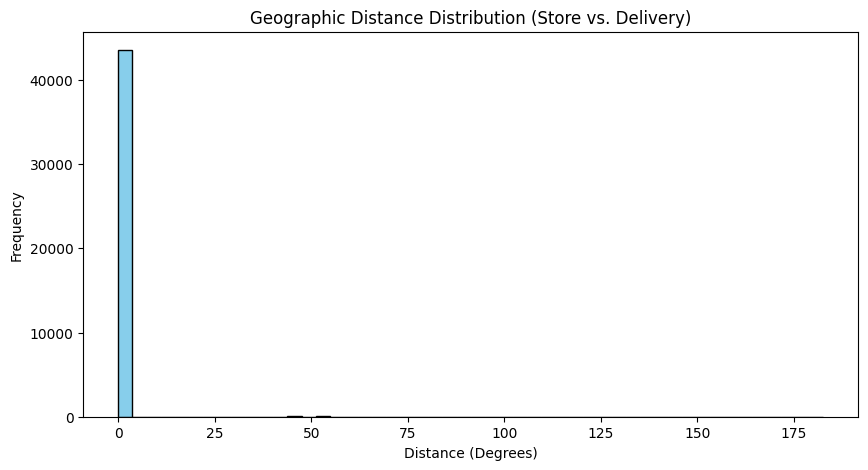

In [37]:
# Cálculo simplificado de distância euclidiana (em graus) para análise de distribuição
dfDelivery['Dist_Euclidiana'] = np.sqrt(
    (dfDelivery['Store_Latitude'] - dfDelivery['Drop_Latitude'])**2 + 
    (dfDelivery['Store_Longitude'] - dfDelivery['Drop_Longitude'])**2
)

plt.figure(figsize=(10, 5))
plt.hist(dfDelivery['Dist_Euclidiana'], bins=50, color='skyblue', edgecolor='black')
plt.title('Geographic Distance Distribution (Store vs. Delivery)')
plt.xlabel('Distance (Degrees)')
plt.ylabel('Frequency')
plt.show()

The plotting of the Euclidean Distance (measured in decimal degrees) between the point of origin (Store) and the destination (Delivery) reveals crucial characteristics about the nature of the dataset and the presence of anomalies:

Predominance of Short Distances: The vast majority of records (~43,000) are concentrated in the first bar of the histogram, extremely close to zero. This indicates that the logistical operation is essentially local, with the store and the customer located in the same neighborhood or city.

Identification of Extreme Outliers: The graph reveals a "long tail" with isolated records at distances exceeding 50, 100, and even 175 degrees. Considering that the Earth's total circumference is 360 degrees, distances of this magnitude are impossible for ground deliveries and confirm severe coordinate errors (such as the negative or zeroed values identified previously).

Justification for Intra-municipal Classification: The massive concentration of data on the far left of the graph mathematically validates the final analysis result: nearly 100% of valid flows are Intra-municipal. Distances that deviate from this pattern do not represent actual long-distance deliveries, but rather technical noise that must be filtered.

# Exploration of the Cities Database (Reference)


--- Top 10 Reference Cities ---
           name_of_city      state_name  population_total
185     Greater Mumbai      MAHARASHTRA          12478447
141              Delhi     NCT OF DELHI          11007835
72            Bengaluru       KARNATAKA           8425970
184  Greater Hyderabad   ANDHRA PRADESH           6809970
7            Ahmadabad          GUJARAT           5570585
119            Chennai       TAMIL NADU           4681087
274            Kolkata      WEST BENGAL           4486679
449              Surat          GUJARAT           4462002
380               Pune      MAHARASHTRA           3115431
225             Jaipur        RAJASTHAN           3073350


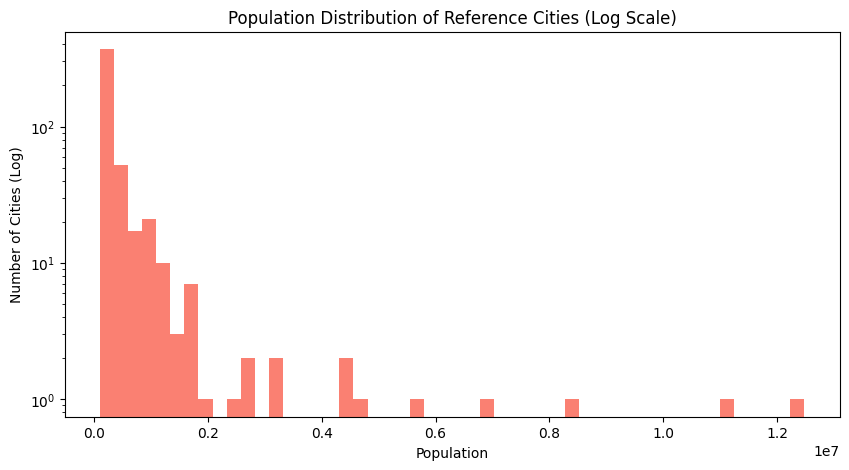

In [39]:
# Top 10 cidades por população no dataset de referência
top_cities = dfCities.sort_values(by='population_total', ascending=False).head(10)
print("\n--- Top 10 Reference Cities ---")
print(top_cities[['name_of_city', 'state_name', 'population_total']])

# Histograma da População (Escala Logarítmica para melhor visualização)
plt.figure(figsize=(10, 5))
plt.hist(dfCities['population_total'], bins=50, color='salmon', log=True)
plt.title('Population Distribution of Reference Cities (Log Scale)')
plt.xlabel('Population')
plt.ylabel('Number of Cities (Log)')
plt.show()

The analysis of the demographic profile reveals that the baseline is strategically anchored in India’s largest urban centers, notably metropolises like Greater Mumbai and Delhi, which have approximately 12.4 and 11 million inhabitants, respectively. Although the dataset relies on these urban masses, the population distribution visualized on a logarithmic scale demonstrates a dense network of smaller cities. This favors the proximity search algorithm (geodesic) by ensuring real urban "anchors" for delivery points and minimizing distortions in metropolitan areas.

Regarding logistical validation, the Euclidean Distance histogram serves as a fundamental diagnostic of the operation. The high-frequency peak near zero confirms that the vast majority of the 43,739 deliveries occur within very short radii, characterizing a typical Last-Mile operation. On the other hand, this same metric exposes severe inconsistencies: records with distances between 50 and 175 degrees are physically impossible, given that a single degree of latitude is equivalent to approximately 111 km. Such discrepancies reinforce the critical need to handle negative signals and remove the zeroed latitudes identified previously. In short, the attribute exploration points to a highly localized and efficient operation, whose flows are predominantly intra-municipal, validating the robustness of the base for geographic enrichment after removing the typical noise of GPS collection.

# Visualizing Raw Data on the Map

C:\Users\Samuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\Samuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\Samuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\Samuel\AppData\L

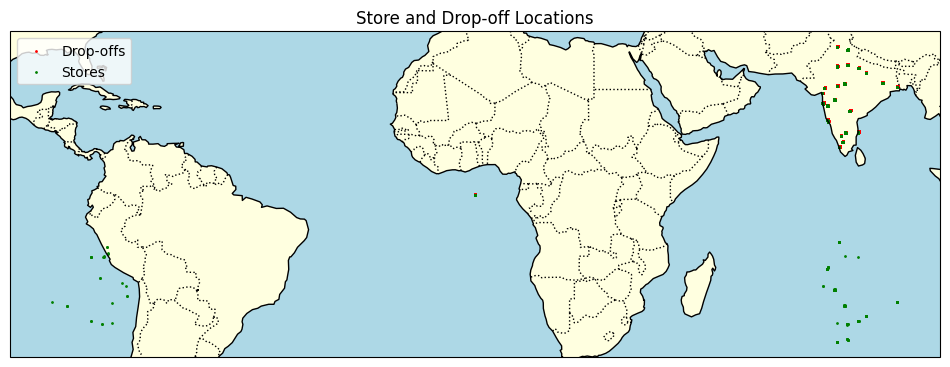

In [18]:
# Create a figure with PlateCarree projection (simple latitude-longitude map)
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features: coastlines, land, ocean, borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightyellow')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot drop-off locations in red
ax.scatter(
    dfDelivery['Drop_Longitude'],
    dfDelivery['Drop_Latitude'],
    color='red',
    s=1,
    label='Drop-offs'
)

# Plot store locations in green
ax.scatter(
    dfDelivery['Store_Longitude'],
    dfDelivery['Store_Latitude'],
    color='green',
    s=1,
    label='Stores'
)

# Add title and legend
plt.title('Store and Drop-off Locations')
plt.legend(loc='upper left')

# Show the map
plt.show()

# Geospatial Data Preprocessing

In [19]:
# Filter out records with invalid coordinates (latitude equal to zero)
dfDelivery = dfDelivery[~(dfDelivery['Store_Latitude'] == 0)]

# Correct coordinates that fall in the ocean by flipping negative values
dfDelivery.loc[dfDelivery['Store_Latitude'] <=0, 'Store_Latitude'] = dfDelivery.loc[dfDelivery['Store_Latitude'] <=0, 'Store_Latitude'] * (-1.0)
dfDelivery.loc[dfDelivery['Store_Longitude'] <=0, 'Store_Longitude'] = dfDelivery.loc[dfDelivery['Store_Longitude'] <=0, 'Store_Longitude'] * (-1.0)


# Visualizing Processed Data on the Map

C:\Users\Samuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\Samuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\Samuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\Samuel\AppData\Local\P

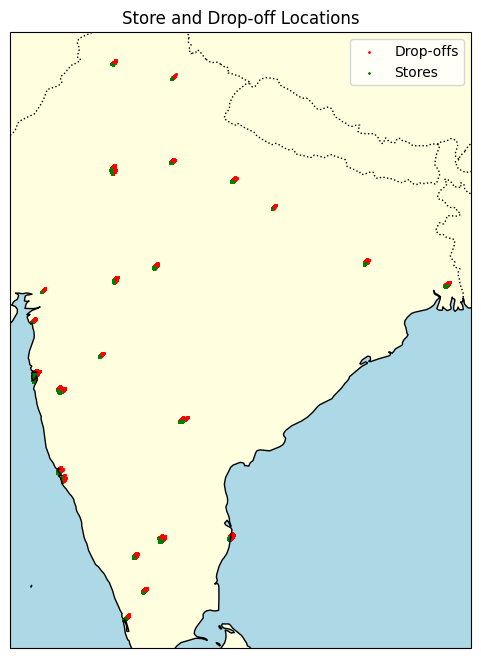

In [20]:
# Create a figure with PlateCarree projection (simple latitude-longitude map)
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features: coastlines, land, ocean, borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightyellow')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot drop-off locations in red
ax.scatter(
    dfDelivery['Drop_Longitude'],
    dfDelivery['Drop_Latitude'],
    color='red',
    s=1,
    label='Drop-offs'
)

# Plot store locations in green
ax.scatter(
    dfDelivery['Store_Longitude'],
    dfDelivery['Store_Latitude'],
    color='green',
    s=1,
    label='Stores'
)

# Add title and legend
plt.title('Store and Drop-off Locations')
plt.legend(loc='upper right')

# Show the map
plt.show()


There are more than 20 clusters across the Indian territory.
1. Next, a clustering algorithm will be applied to identify groups of locations with similar geographic proximity.
2. After that, we will attempt to determine the cities corresponding to each location.
3. Finally, we will classify the flow type into the following categories: intramunicipal, intermunicipal, and interstate.

# Preparing Coordinate Data

In [21]:
# Extract store coordinates and remove duplicate latitude–longitude pairs
dfCoordStore = dfDelivery[['Store_Latitude', 'Store_Longitude']]
dfCoordStore = dfCoordStore.drop_duplicates(ignore_index=True)

# Extract drop-off coordinates and remove duplicate latitude–longitude pairs
dfCoordDrop = dfDelivery[['Drop_Latitude', 'Drop_Longitude']]
dfCoordDrop = dfCoordDrop.drop_duplicates(ignore_index=True)

# Rename columns in both DataFrames to a unified format
dfCoordStore = dfCoordStore.rename(columns={'Store_Latitude': 'Latitude','Store_Longitude': 'Longitude'})
dfCoordDrop = dfCoordDrop.rename(columns={'Drop_Latitude': 'Latitude','Drop_Longitude': 'Longitude'})

# Concatenate store and drop-off coordinate sets into a single DataFrame
dfCoords = pd.concat([dfCoordStore, dfCoordDrop], ignore_index=True)

# Convert coordinates to a NumPy array for further processing
coords = dfCoords.to_numpy()

#  Clustering with BSDCAN Algorithm

In [22]:
# Radius of the Earth in kilometers, used to convert distance to radians
kms_per_radian = 6371.0088

# Define neighborhood size for DBSCAN
#epsilon = 3.5 / kms_per_radian
epsilon = 10 / kms_per_radian

# Apply DBSCAN clustering using the Haversine distance metric (coordinates provided in radians) and Ball Tree algorithm, that can efficiently find neighbors on the sphere
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

# Extract cluster labels assigned to each coordinate pair
cluster_labels = db.labels_

# Count the number of unique clusters
num_clusters = len(set(cluster_labels))

# Group coordinate points by cluster into a Pandas Series for further analysis
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

# Display total number of detected clusters
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 24


The number of clusters aligns with expectations.

# Observing the Clusterization Results

In [23]:
clusters

0     [[22.745049, 75.892471], [22.74806, 75.8934], ...
1     [[12.913041, 77.683237], [12.914264, 77.6784],...
2     [[11.003669, 76.976494], [11.022477, 76.995667...
3     [[12.972793, 80.249982], [12.986047, 80.218114...
4     [[17.431668, 78.408321], [17.433809, 78.386744...
5     [[23.369746, 85.33982], [23.357804, 85.325146]...
6     [[12.352058, 76.60665], [12.311072, 76.654878]...
7     [[30.327968, 78.046106], [30.372202, 78.077151...
8     [[10.003064, 76.307589], [10.035573, 76.336958...
9     [[18.56245, 73.916619], [18.592718, 73.773572]...
10    [[30.899584, 75.809346], [30.89286, 75.822199]...
11    [[26.463504, 80.372929], [26.479108, 80.315042...
12    [[19.176269, 72.836721], [19.221315, 72.862381...
13    [[22.552672, 88.352885], [22.539129, 88.365507...
14    [[26.849596, 75.800512], [26.88842, 75.800689]...
15    [[21.160522, 72.771477], [21.160437, 72.774209...
16    [[15.51315, 73.78346], [15.561295, 73.749478],...
17    [[27.165108, 78.015053], [27.163303, 78.05

# Calculating the Centermost Point of Each Cluster

In [24]:
# Function to find the point in a cluster closest to the geometric centroid
def getCentermostPoint(cluster):
    # Compute the centroid of the cluster
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)

    # Find the point in the cluster closest to the centroid
    centermostPoint = min(cluster, key=lambda point: great_circle(point, centroid).m)

    return tuple(centermostPoint)

# Apply the function to each cluster
centermost_points = clusters.map(getCentermostPoint)

# Display DataFrame
centermost_points

0     (22.794648, 75.944377)
1     (13.013298, 77.694293)
2     (11.063681, 77.035525)
3     (13.094347, 80.297221)
4     (17.491668, 78.468321)
5      (23.419746, 85.38982)
6     (12.383225, 76.690028)
7     (30.407968, 78.126106)
8     (10.053064, 76.357589)
9     (18.610963, 73.908972)
10    (30.955562, 75.882841)
11    (26.539003, 80.386344)
12    (19.171458, 72.907808)
13    (22.599129, 88.425507)
14    (26.962328, 75.854257)
15    (21.225975, 72.845503)
16    (15.606594, 73.820431)
17    (27.235108, 78.085053)
18    (25.520317, 81.901681)
19    (22.371358, 73.224798)
20    (19.936106, 75.400775)
21    (23.282537, 77.479845)
22    (15.217944, 74.010889)
23    (15.363897, 73.974336)
dtype: object

# Mapping Centermost Points to Cluster IDs

In [25]:
# Generate cluster IDs based on the number of centermost points
cluster_ids = range(len(centermost_points))

# Create the DataFrame combining centermost points with cluster IDs
dfClusters = pd.DataFrame({
    'Center': centermost_points,
    'Cluster': cluster_ids
})

# Display DataFrame
dfClusters

,Center,Cluster
0,"(22.794648, 75.944377)",0
1,"(13.013298, 77.694293)",1
2,"(11.063681, 77.035525)",2
3,"(13.094347, 80.297221)",3
4,"(17.491668, 78.468321)",4
5,"(23.419746, 85.38982)",5
6,"(12.383225, 76.690028)",6
7,"(30.407968, 78.126106)",7
8,"(10.053064, 76.357589)",8
9,"(18.610963, 73.908972)",9


# Mapping Cities Related to the Nearest Centermost Points of Each Cluster

In [26]:
# Function to Find the Nearest City and State
def findCityState(tuplaCoord):
  dfCities['Distance'] = dfCities.apply(
      lambda row: geodesic(
          (row['location'][0], row['location'][1]),
           (tuplaCoord[0], tuplaCoord[1])
           ).km,
      axis=1)

  # Find the row with the minimum distance
  nearest_row = dfCities.loc[dfCities['Distance'].idxmin()]

  # Return city and state as a tuple
  return nearest_row['name_of_city'], nearest_row['state_name'], nearest_row['population_total'], float(nearest_row['location'][0]), float(nearest_row['location'][1])

# Assign City and State to Each Cluster
dfClusters[['City', 'State', 'Population', 'Latitude', 'Longitude']] = dfClusters['Center'].apply(lambda x: pd.Series(findCityState(x)))

# Display DataFrame
dfClusters

,Center,Cluster,City,State,Population,Latitude,Longitude
0,"(22.794648, 75.944377)",0,Indore,MADHYA PRADESH,1960631,22.719569,75.857726
1,"(13.013298, 77.694293)",1,Bengaluru,KARNATAKA,8425970,12.971600,77.594600
2,"(11.063681, 77.035525)",2,Coimbatore,TAMIL NADU,1061447,11.016844,76.955832
3,"(13.094347, 80.297221)",3,Chennai,TAMIL NADU,4681087,13.082680,80.270718
4,"(17.491668, 78.468321)",4,Secunderabad,ANDHRA PRADESH,213698,17.439930,78.498274
5,"(23.419746, 85.38982)",5,Ranchi,JHARKHAND,1073440,23.344100,85.309562
6,"(12.383225, 76.690028)",6,Mysore,KARNATAKA,887446,12.295810,76.639381
7,"(30.407968, 78.126106)",7,Dehradun,UTTARAKHAND,578420,30.316495,78.032192
8,"(10.053064, 76.357589)",8,Kochi,KERALA,601574,9.931233,76.267304
9,"(18.610963, 73.908972)",9,Pune,MAHARASHTRA,3115431,18.520430,73.856744


# Visualizing Points, Clusters, and Related Cities on the Map

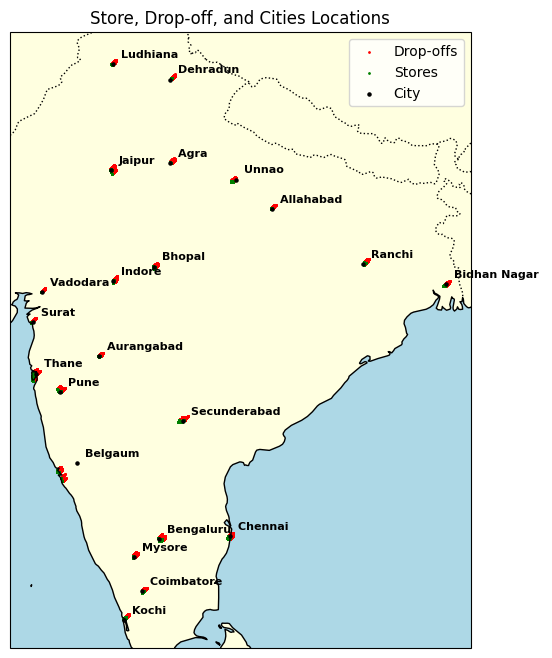

In [27]:
# Select data and remove duplicates
dfClustersCities = dfClusters[['City', 'State', 'Population',	'Latitude',	'Longitude']]
dfClustersCities = dfClustersCities.drop_duplicates(ignore_index=True)

# Map Visualization with Stores, Drop-offs, and Cluster Centers
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add basic map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightyellow')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot drop-off locations in red
ax.scatter(
    dfDelivery['Drop_Longitude'],
    dfDelivery['Drop_Latitude'],
    color='red',
    s=1,
    label='Drop-offs'
)

# Plot store locations in green
ax.scatter(
    dfDelivery['Store_Longitude'],
    dfDelivery['Store_Latitude'],
    color='green',
    s=1,
    label='Stores'
)

# Plot cluster centers in black
ax.scatter(
    dfClustersCities['Longitude'],
    dfClustersCities['Latitude'],
    color='black',
    s=5,
    label='City'
)

# Optionally, add city names as text labels
label_offset = 0.1  # degrees latitude
for idx, row in dfClustersCities.iterrows():
    ax.text(
        row['Longitude'] + 3 * label_offset,
        row['Latitude'] + 2.5 * label_offset,
        row['City'],
        fontsize=8,
        color='black',
        weight='bold'
    )

# Add title and legend
plt.title('Store, Drop-off, and Cities Locations')
plt.legend(loc='upper right')

# Show the map
plt.show()


The map visualization indicates that the **DBSCAN algorithm**, computed using Haversine distance and a Ball Tree structure, performed well in identifying clusters based on geographic coordinates. This clustering enabled the **assignment of the nearest cities** to each data point.

However, it is important to acknowledge **limitations** in the **city reference dataset**, which led to some **misclassifications**. Due to the absence of cities located closer to certain observed data points, the city of **Belgaum** was incorrectly assigned as the nearest city to a coastal region in India. This error is primarily attributable to **insufficient geographic coverage** in the **city dataset** rather than to the clustering methodology itself.

DBSCAN is an **unsupervised learning technique** that groups observations based on density and assigns proximity using distance-based criteria. While the overall clustering results were satisfactory, their accuracy remains constrained by the **quality and completeness of the geographic data**. This outcome highlights the strong dependency on high-quality, well-distributed reference data when geographic datasets are used for enrichment and spatial inference.


# Flow Classification

In [28]:
# Extract Cluster Coordinates
dfClusterMerge = pd.DataFrame({
    'Latitude': coords[:, 0].astype('float64'),
    'Longitude': coords[:, 1].astype('float64'),
    'Cluster': cluster_labels.astype('int64')
})

# Identify Store Cluster
dfDeliveryCluster = pd.merge(dfDelivery, dfClusterMerge, left_on=['Store_Latitude','Store_Longitude'], right_on=['Latitude','Longitude'], how='inner')
dfDeliveryCluster.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
dfDeliveryCluster = dfDeliveryCluster.rename(columns={'Cluster': 'Cluster_Store'})

# Identify Drop Cluster
dfDeliveryCluster = pd.merge(dfDeliveryCluster, dfClusterMerge, left_on=['Drop_Latitude','Drop_Longitude'], right_on=['Latitude','Longitude'], how='inner')
dfDeliveryCluster.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
dfDeliveryCluster = dfDeliveryCluster.rename(columns={'Cluster': 'Cluster_Drop'})

# Identify Store City
dfDeliveryCluster = pd.merge(dfDeliveryCluster, dfClusters, left_on=['Cluster_Store'], right_on='Cluster', how='inner')
dfDeliveryCluster.drop(['Center', 'Cluster'], axis=1, inplace=True)
dfDeliveryCluster = dfDeliveryCluster.rename(columns={'City': 'City_Store', 'Population': 'Population_Store', 'State': 'State_Store'})

# Identify Drop City
dfDeliveryCluster = pd.merge(dfDeliveryCluster, dfClusters, left_on=['Cluster_Drop'], right_on='Cluster', how='inner')
dfDeliveryCluster.drop(['Center', 'Cluster'], axis=1, inplace=True)
dfDeliveryCluster = dfDeliveryCluster.rename(columns={'City': 'City_Drop', 'Population': 'Population_Drop', 'State': 'State_Drop'})

# Remove Cluster
dfDeliveryCluster.drop(['Cluster_Store', 'Cluster_Drop'], axis=1, inplace=True)
dfDeliveryCluster

# Function to classify the type of delivery flow based on store and drop-off locations
def flowType(cityStore, stateStore, cityDrop, stateDrop):
  if stateStore != stateDrop:
    return 'Interstate'
  elif cityStore == cityDrop:
    return 'Intramunicipal'
  else:
    return 'Interstate'

# Apply the flowType function to each row of the DataFrame
dfDeliveryCluster['Flow_Type'] = dfDeliveryCluster.apply(
    lambda row: flowType(row['City_Store'], row['State_Store'], row['City_Drop'], row['State_Drop']),
      axis=1)

# Display DataFrame
dfDeliveryCluster

,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Dist_Euclidiana,City_Store,State_Store,Population_Store,Latitude_x,Longitude_x,City_Drop,State_Drop,Population_Drop,Latitude_y,Longitude_y,Flow_Type
0,22.745049,75.892471,22.765049,75.912471,0.028284,Indore,MADHYA PRADESH,1960631,22.719569,75.857726,Indore,MADHYA PRADESH,1960631,22.719569,75.857726,Intramunicipal
1,12.913041,77.683237,13.043041,77.813237,0.183848,Bengaluru,KARNATAKA,8425970,12.971600,77.594600,Bengaluru,KARNATAKA,8425970,12.971600,77.594600,Intramunicipal
2,12.914264,77.678400,12.924264,77.688400,0.014142,Bengaluru,KARNATAKA,8425970,12.971600,77.594600,Bengaluru,KARNATAKA,8425970,12.971600,77.594600,Intramunicipal
3,11.003669,76.976494,11.053669,77.026494,0.070711,Coimbatore,TAMIL NADU,1061447,11.016844,76.955832,Coimbatore,TAMIL NADU,1061447,11.016844,76.955832,Intramunicipal
4,12.972793,80.249982,13.012793,80.289982,0.056569,Chennai,TAMIL NADU,4681087,13.082680,80.270718,Chennai,TAMIL NADU,4681087,13.082680,80.270718,Intramunicipal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40229,23.371292,85.327872,23.481292,85.437872,0.155563,Ranchi,JHARKHAND,1073440,23.344100,85.309562,Ranchi,JHARKHAND,1073440,23.344100,85.309562,Intramunicipal
40230,26.902328,75.794257,26.912328,75.804257,0.014142,Jaipur,RAJASTHAN,3073350,26.912434,75.787271,Jaipur,RAJASTHAN,3073350,26.912434,75.787271,Intramunicipal
40231,13.022394,80.242439,13.052394,80.272439,0.042426,Chennai,TAMIL NADU,4681087,13.082680,80.270718,Chennai,TAMIL NADU,4681087,13.082680,80.270718,Intramunicipal
40232,11.001753,76.986241,11.041753,77.026241,0.056569,Coimbatore,TAMIL NADU,1061447,11.016844,76.955832,Coimbatore,TAMIL NADU,1061447,11.016844,76.955832,Intramunicipal


# Flow Type Distribution

In [29]:
# Display the count of each flow type in the DataFrame
dfDeliveryCluster['Flow_Type'].value_counts()

Flow_Type
Intramunicipal    40234
Name: count, dtype: int64

This time, we got lucky and were handed a dataset that contained **only intramunicipal flows**.  

With that, we wrap up our analysis. However, things could look different if the same algorithm were applied to another dataset with more diverse flows.

Feel free to take the code and give it a spin with your own data to explore how the classifications could change!

Last but not least, we save the enriched dataset from this study.

# Market Concentration (Delivery Volume by State)

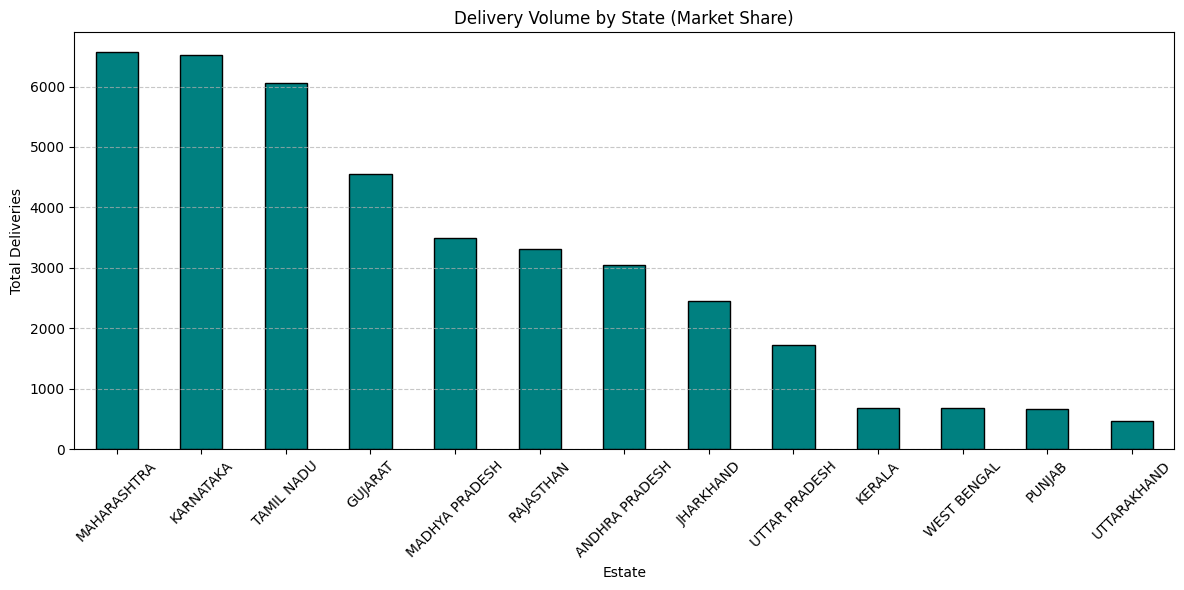

In [40]:
state_counts = dfDeliveryCluster['State_Store'].value_counts()

plt.figure(figsize=(12, 6))
state_counts.plot(kind='bar', color='teal', edgecolor='black')
plt.title('Delivery Volume by State (Market Share)')
plt.xlabel('Estate')
plt.ylabel('Total Deliveries')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Market analysis demonstrates a clear dominance of economic hubs, with a strategic concentration of delivery volumes in the states of Maharashtra and Karnataka, which lead the rankings with over 6,000 records each. This prominence is a direct reflection of the presence of Mumbai, the country's largest financial center, and Bengaluru, the primary technology hub known as the Indian "Silicon Valley." Tamil Nadu establishes itself as the third-largest market, reaffirming the relevance of the South and West axis in the distribution network, while lower volumes in states like Kerala, West Bengal, and Punjab suggest both areas of opportunity for expansion and a strategy deliberately focused on high-density urban zones.

This spatial distribution validates the effectiveness of the Last-Mile strategy, evidenced by the intersection between state volume and the geographic distance of operations. The massive concentration of deliveries with near-zero displacement indicates a highly capillary network, where dispatch units are positioned within major consumer centers to optimize response times. It is important to note that the distance outliers identified previously were isolated as technical noise, ensuring that the state-by-state analysis reflects operational reality rather than system distortions.

Finally, a precise demographic synergy is observed between the logistical infrastructure and the population of the reference cities. The fact that capitals and metropolises with populations between 8 and 12 million inhabitants are located in the volume-leading states proves that the logistics network is perfectly aligned with population density. This harmony allows for the mastery of intra-municipal flows, converting demographic mass into operational efficiency and faster deliveries, grounded in a now properly sanitized database.

# Relationship: Population vs. Demand

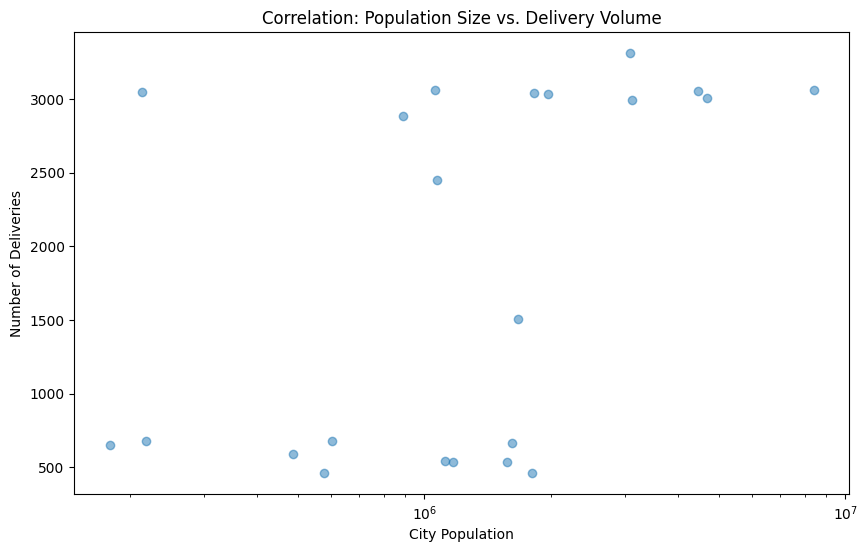

In [41]:
# Grouping by city to see the correlation
city_analysis = dfDeliveryCluster.groupby('City_Store').agg({
    'Population_Store': 'first',
    'City_Store': 'count'
}).rename(columns={'City_Store': 'Delivery_Count'})

plt.figure(figsize=(10, 6))
plt.scatter(city_analysis['Population_Store'], city_analysis['Delivery_Count'], alpha=0.5)
plt.title('Correlation: Population Size vs. Delivery Volume')
plt.xlabel('City Population')
plt.ylabel('Number of Deliveries')
plt.xscale('log')
plt.show()

The analysis of the scatter plot under a logarithmic scale reveals a fundamental characteristic for strategic planning: the non-linearity of demand relative to population size. A standout finding is the formation of a significant cluster of mid-sized cities, with populations between $10^5$ and $10^6$ inhabitants, which already record delivery volumes exceeding 3,000 orders. This performance, which directly rivals that of major metropolises, suggests that service penetration has reached a stage of high efficiency in secondary urban centers.However, the dataset also exposes high operational variability, where cities with similar demographic profiles present drastically different delivery volumes, ranging from 500 to over 3,000 records. This disparity indicates that logistical success does not depend exclusively on the size of the population but is strongly conditioned by structural factors, such as the quality of local infrastructure and the strategic proximity of distribution centers.

In [ ]:
# Saving Enriched Data
dfDeliveryCluster.to_csv('/content/drive/MyDrive/Portfólio/Rede delivery/delivery_enrich.csv')

# Conclusion: 
Strategic Logistics and Data IntegrityThe analysis of this delivery dataset provided a comprehensive overview of the operational landscape in India, revealing a robust logistical network that is deeply integrated into the country's main economic and demographic hubs.1. Data Integrity and Geospatial ReliabilityThe initial stages of the project were critical in ensuring the quality of the insights. By isolating geographic outliers and technical noise—specifically coordinates falling outside India's territory—we transformed raw data into a sanitized, high-fidelity database. The verification of the "Store vs. Delivery" distance distribution confirmed that most operations are highly localized, validating the data's consistency.2. Market Dominance and High-Density StrategyThe clear leadership of states like Maharashtra, Karnataka, and Tamil Nadu underscores a strategy focused on high-value urban centers. The concentration of deliveries in financial and technological hubs (Mumbai and Bengaluru) proves that the operation is currently optimized to capture demand where purchasing power and digital infrastructure are most mature.3. The Power of Mid-Sized Cities (The "Next Tier")One of the most valuable findings was the identification of a high-performing cluster of secondary cities (populations between $10^5$ and $10^6$). The fact that these cities rival metropolises in delivery volume suggests that market penetration is no longer restricted to "Tier 1" cities, presenting a massive opportunity for scalable growth in regional hubs.4. Operational Efficiency and Last-Mile DeliveryThe "near-zero" distance trend between store and consumer confirms the success of a Last-Mile approach. However, the variability observed in cities with similar populations indicates that physical infrastructure and distribution center placement are just as critical as demographic size.Final OutlookThis project demonstrates that while population density provides the opportunity for volume, logistical capillarity and data-driven optimization are what convert that potential into operational success. The sanitized dataset now serves as a reliable foundation for predictive modeling, route optimization, and future expansion strategies.